Sprawozdanie z realizacji projektu "Analizy filmów na podstawie https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset" wykonywanego w ramach przedmiotu Podstawy Reprezentacji i Analizy Danych.

Celem projektu było stworzenie modelu mogącego dopasować filmy do podanych gatunków na podstawie dostępnych ze zbioru danych.

Członkowie zespołu: Jordan Parviainen, Jakub Niewadzi, Szymon Posiadała.

W celu zrealizowania projektu wykorzystaliśmy uczenie nadzorowane, a konkretnie naiwny algorytm Bayesa oraz SVC. Użyliśmy dwóch algorytmów, aby można było porównać wyniki uczeia się dla obu i wybrać lepszy.

Pobrane dane mają strukturę tablicy o kolumnach id, genres, overview, id, release_date, vote_count, vote_average, runtime, title.
Pobraliśmy 45 466 takich kolumn, natomiast po odrzuceniu skrajnych plików pozostało nam 31524
Na tym etapie byliśmy w stanie wyznaczyć podstawowe wartości, takie jak średnia ocen wszystkich filmów, średnia długość czasu trwania, oraz zobaczyć histogramy interesujących nas wartości




Importowanie bibliotek niezbędnych do działania programu:

In [1]:
from azureml.core import Workspace, Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn import tree
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.color import rgb2gray
from skimage.exposure import histogram
from datetime import datetime
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
import string
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.display.float_format = "{:.3f}".format 

Konfiguracja Azure i pobranie danych:

In [2]:
subscription_id = '2e950711-3856-43c9-a2db-c2c17d51a26e'
resource_group = 'PRiAD'
workspace_name = 'PRIADfilmy'
workspace = Workspace(subscription_id, resource_group, workspace_name)
dataset = Dataset.get_by_name(workspace, name='Movies_data_preprocessed')
dataset.download(target_path='.', overwrite=True)


['/mnt/batch/tasks/shared/LS_root/mounts/clusters/jordus1001/code/Users/01169610/_meta.yaml',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/jordus1001/code/Users/01169610/schema/_schema.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/jordus1001/code/Users/01169610/_samples.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/jordus1001/code/Users/01169610/data.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/jordus1001/code/Users/01169610/data.visualization']

Analizowane dane pochodzą ze zbiorów Movielens, pobranych przy pomocy strony https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

Po wczytaniu początkowych danych do 'data.csv' otrzymaliśmy plik daleki od naszych oczekiwań. Przed obróbką 'dane.csv' zawierały między innymi:
- filmy o długości poniżej 1 minuty;
- filmy o długości powyżej 5 godzin, z najdłuższym trwającym około 1200 minut;
- filmy bez ocen;
- filmy bez opisów;
- bardzo stare filmy, sprzed 1950 roku;
- filmy nie przypisane do żadnego gatunku;
- gatunki filmów zbite w pseudo-json'y;
- filmy przynależące do wielu gatunków

Informacje te uzyskaliśmy między innymi analizując poniższe wykresy, jak również surowe pliki z danymi.

Pobieranie pliku i początki analizy eksploracyjnej:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        45466 non-null  object 
 1   id            45466 non-null  object 
 2   overview      44507 non-null  object 
 3   release_date  45379 non-null  object 
 4   runtime       45203 non-null  float64
 5   title         45460 non-null  object 
 6   vote_average  45460 non-null  float64
 7   vote_count    45460 non-null  float64
dtypes: float64(3), object(5)
memory usage: 2.8+ MB


<Figure size 800x800 with 0 Axes>

Average rating mean:5.618207215133889 standard deviation:1.9242159915229755
Average rating varies from 0.0 to 10.0


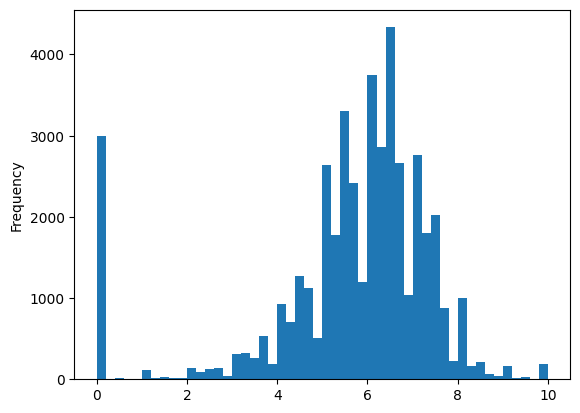

Runtime mean:94.12819945578833 standard deviation:38.40781048550736
Runtime varies from 0.0 to 1256.0


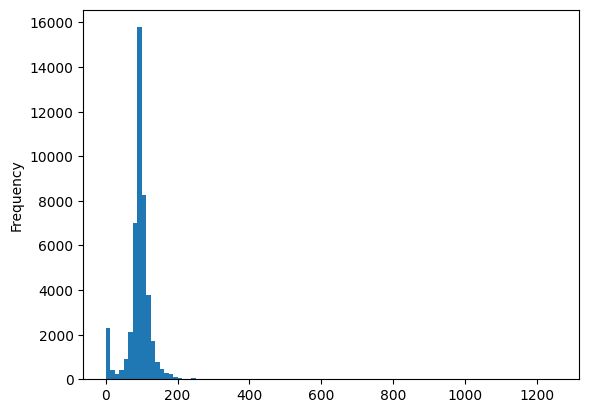

Vote count mean:109.89733831940167 standard deviation:491.3103739397137
Vote count varies from 0.0 to 14075.0


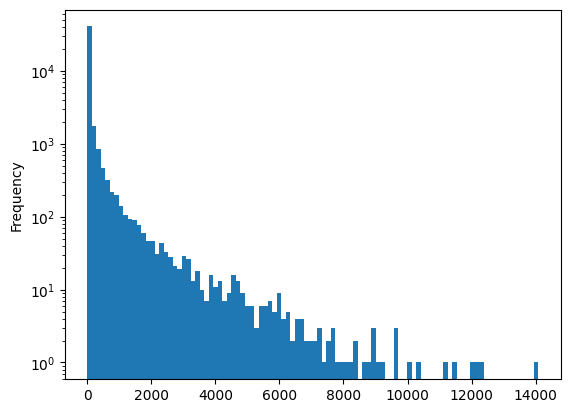


Number of unique genres:4069
["Unique genres:[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"
 "Unique genres:[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]"
 "Unique genres:[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"
 ...
 "Unique genres:[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name': 'Comedy'}, {'id': 28, 'name': 'Action'}, {'id': 10751, 'name': 'Family'}]"
 "Unique genres:[{'id': 28, 'name': 'Action'}, {'id': 9648, 'name': 'Mystery'}, {'id': 53, 'name': 'Thriller'}, {'id': 27, 'name': 'Horror'}]"
 "Unique genres:[{'id': 10751, 'name': 'Family'}, {'id': 16, 'name': 'Animation'}, {'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"]


In [3]:
df = pd.read_csv('data.csv')
df.info()

plt.figure(figsize=(10,10), dpi= 80)

#Wykres, średnia i odchylenie standardowe oceny filmów
plt.show()
df['vote_average'].plot.hist(bins=50)
print("Average rating mean:"+str(df['vote_average'].mean())+' standard deviation:'+str(df['vote_average'].std()))
print("Average rating varies from "+str(df['vote_average'].min())+" to "+str(df['vote_average'].max()))
plt.show()

#Wykres, średnia i odchylenie standardowe czasu trwania filmów
df['runtime'].plot.hist(bins=100)
print("Runtime mean:"+str(df['runtime'].mean())+' standard deviation:'+str(df['runtime'].std()))
print("Runtime varies from "+str(df['runtime'].min())+" to "+str(df['runtime'].max()))
plt.show()

#Wykres, średnia i odchylenie standardowe ilości recenzji
df['vote_count'].plot.hist(bins=100,log=True)
print("Vote count mean:"+str(df['vote_count'].mean())+' standard deviation:'+str(df['vote_count'].std()))
print("Vote count varies from "+str(df['vote_count'].min())+" to "+str(df['vote_count'].max()))
plt.show()
print()

#Ilość i rodzaje gatunków
print("Number of unique genres:"+str(df['genres'].nunique()))
print("Unique genres:"+df['genres'].unique())

Pierwszy wykres przedstawia średnią ocenę filmów, dzięki niemu widzimy że dużo filmów miały ocenę 0. Drugi wykres przedstawia czas trwania filmów. Można na nim zauważyć bardzo małą liczbę filmów trwających dłużej niż 300 minut. Trzeci wykres przedstawia liczbę ocen filmów, widać na nim że spora ilość filmów nie ma ocen i mogą być zbędnymi danymi. Zbierając zdobyte infromacje z wykresów można było zauważyć, że jest nadmiarowa liczba filmów mająca zarówno oceny 0, jak i 0 oddanych głosów, co sugeruje powiązanie między tymi parametrami. Po usunięciu brakujących danych, jak i "odchudzeniu" zbioru na podstawie podstawowych informacji otrzymaliśmy następujące dane.

In [4]:
#usunięcie brakujących danych
df = df.dropna()
print("liczba obiektów: ", df.count(0)[0])

df=df.sort_values('runtime', ascending=False)
#usunięcie filmów trwających ponad 5 godzin
df.drop(df[df['runtime'] >= 300].index, inplace = True)
#usunięcie filmów trwających mniej niż 1 minutę
df.drop(df[df['runtime'] <= 1].index, inplace = True)
#usunięcie filmów bez oceny
df.drop(df[df['vote_count'] == 0].index, inplace = True)


#usunięcie filmów które wyszły przed 1960 rokiem
dates=[]
for element in df['release_date']:
    dates.append(datetime.strptime(element, '%Y-%m-%d').date().year)


df['release_date']=dates

df = df.dropna()
print(type(df['release_date'][0]))

df.drop(df[df['release_date'] <1960].index, inplace = True)

print("liczba obiektów: ", df.count(0)[0])


liczba obiektów:  44430
<class 'numpy.int64'>
liczba obiektów:  35712


Klasami w zestawie danych są gatunki, a cechy to: opis, data wydania, średnia ocen, ilość ocen. W danych źródłowych mamy 45466 obiektów, lecz po wyrzuceniu brakujących danych, skrajnych danych (np. filmy które trwają ponad 5 godzin) i ustawieniu daty najstarszych filmów na 1960 rok zostało nam ich jedynie 35712.

Average rating mean:5.99996639784925 standard deviation:1.2554535618358154
Average rating varies from 0.0 to 10.0


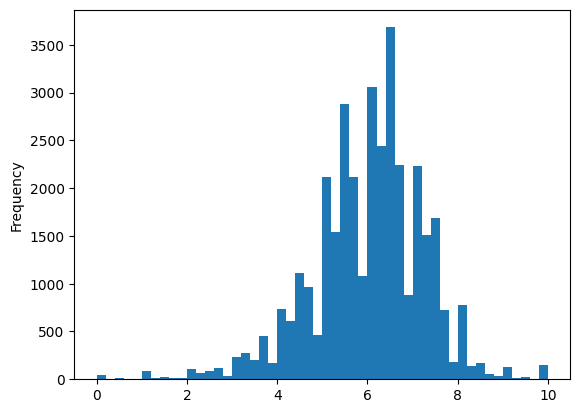

Runtime mean:98.84828629032258 standard deviation:25.73440794579435
Runtime varies from 2.0 to 298.0


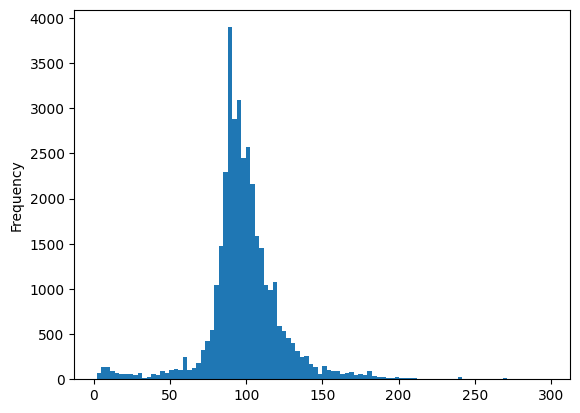

Vote count mean:136.07890905017922 standard deviation:550.0630522213452
Vote count varies from 1.0 to 14075.0


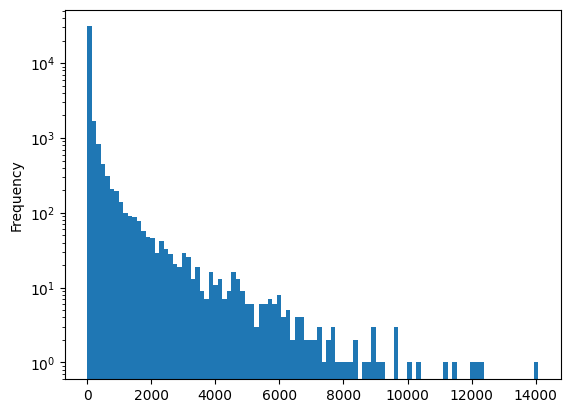

In [85]:
#Wykres, średnia i odchylenie standardowe oceny filmów
plt.show()
df['vote_average'].plot.hist(bins=50)
print("Average rating mean:"+str(df['vote_average'].mean())+' standard deviation:'+str(df['vote_average'].std()))
print("Average rating varies from "+str(df['vote_average'].min())+" to "+str(df['vote_average'].max()))
plt.show()

#Wykres, średnia i odchylenie standardowe czasu trwania filmów
df['runtime'].plot.hist(bins=100)
print("Runtime mean:"+str(df['runtime'].mean())+' standard deviation:'+str(df['runtime'].std()))
print("Runtime varies from "+str(df['runtime'].min())+" to "+str(df['runtime'].max()))
plt.show()

#Wykres, średnia i odchylenie standardowe ilości recenzji
df['vote_count'].plot.hist(bins=100,log=True)
print("Vote count mean:"+str(df['vote_count'].mean())+' standard deviation:'+str(df['vote_count'].std()))
print("Vote count varies from "+str(df['vote_count'].min())+" to "+str(df['vote_count'].max()))
plt.show()
print()

Jak widać, po usunięciu niepotrzebnych danych wykres czasu trwania filmów znacząco zawężył się, po usunięciu filmów bez ocen zniknęły również filmy, które miały średnią ocen 0.

Kolejnym krokiem na drodze przefiltrowania i analizy zbioru danych wejściowych było zajęcie się kolumną "genres". Krok pierwszy - zamiana formatu a'la JSON, w którym były zapisane dane o gatunkach filmów na zwykłe listy. 

In [5]:
import json
unique_genres = set()
genres_count = dict()
#obrabienie jsonów
def process_genres(genres):
    genres = genres[1:len(genres)-1]
    genres = genres.split("}, ")
    row_genres = []
    for genre in genres:
        if(len(genre)>1):
            if(genre[len(genre)-1] != "}"):
                genre += "}"
            genre = genre.replace("'", '"')
            genres_json = json.loads(genre)
            genre_name = genres_json["name"]
            row_genres.append(genre_name)
            if(genre_name in genres_count):
                genres_count[genre_name] +=1
            else:
                genres_count[genre_name] = 1
                unique_genres.add(genre_name)
    return row_genres
df2 = df.copy()
#zamiana na tablice gatunków
df2['genres'] = [process_genres(x) for x in df['genres']]


Następnie - przeanalizowanie jakie zestawy gatunków pojawiają się najczęściej i w jakiej ilości.

In [6]:
#liczenie filmów dla każdego gatunku
df2['genres_str'] = [''.join(x) for x in df['genres']]
df2.head(10)
unique_genres = dict()
def count_unique_genres(genre_name):
    if(genre_name in unique_genres):
        unique_genres[genre_name] +=1
    else:
        unique_genres[genre_name] = 1
[count_unique_genres(x) for x in df2['genres_str']]
unique_genres_keys_sorted = list(dict(sorted(unique_genres.items(), key=lambda x:x[1], reverse=True)).keys())
for i in range(0, 20):
    print(str(unique_genres_keys_sorted[i]) + ' : ' + str(+ unique_genres[unique_genres_keys_sorted[i]]) + '\n')

[{'id': 18, 'name': 'Drama'}] : 3873

[{'id': 35, 'name': 'Comedy'}] : 2654

[{'id': 99, 'name': 'Documentary'}] : 2122

[] : 1145

[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}] : 1015

[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}] : 965

[{'id': 27, 'name': 'Horror'}] : 891

[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}] : 705

[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}] : 517

[{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}] : 506

[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}] : 439

[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}] : 425

[{'id': 53, 'name': 'Thriller'}] : 381

[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}] : 284

[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'name': 'Foreign'}] : 261

[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}] : 260

[{'id': 28, 'name': 'Action'}] : 250

[{'id': 10749, 'name': 'Rom

Ważnym elementem analizy było usunięcie filmów, które nie miały do siebie przypisanego żadnego gatunku, początkowo gatunek był w formacie json, przez co filmy bez gatunku miały puste stringi jako swoją wartość, a nie brak wartości, co uniemożliwiło przefiltrowanie takich filmów na początku. W celu bardziej skutecznej klasyfikacji konieczne było dokonanie pewnych manipulacji i uproszczeń na atrybucie decyzyjnym, czyli kolumnie "genres", w której wiele obiektów miało przypisaną więcej niż jedną wartość. Musieliśmy odrzucić gatunki mało popularne. Trzeba było też scalić wartości, które logicznie były blisko siebie i rozróżnianie ich w klasyfikacji miało małą szansę powodzenia - na przykład para gatunków "thriller" i "kryminał". Aby ocenić, które gatunki można ze sobą scalić przeprowadziliśmy analizę opisów filmów, tak aby móc scalić gatunki, które mają najpodobniejsze do siebie opisy.

In [7]:
#usuwanie filmów bez gatunku
df2.drop(df2[df2['genres'].map(lambda x: len(x) == 0)].index, inplace=True)

print("liczba obiektów: ", df2.count(0)[0])

#zostawianie jednego gatunku dla filmu
main_genres=[]

for element in df2['genres']:
    main_genres.append(element[0])


df2['genres']=main_genres


print("liczba obiektów: ", df2.count(0)[0])
unique_genres = dict()
[count_unique_genres(x) for x in df2['genres']]
unique_genres_keys_sorted = list(dict(sorted(unique_genres.items(), key=lambda x:x[1], reverse=True)).keys())
wanted_genres = unique_genres_keys_sorted[:10]
df2.drop(df2[df2['genres'].map(lambda x: x not in wanted_genres)].index, inplace=True)

print("liczba obiektów: ", df2.count(0)[0])
print(wanted_genres)



liczba obiektów:  34567
liczba obiektów:  34567
liczba obiektów:  31113
['Drama', 'Comedy', 'Action', 'Documentary', 'Horror', 'Thriller', 'Adventure', 'Crime', 'Animation', 'Romance']


W celu analizy tekstu musieliśmy dokonać tokenizacji opisów, czyli rodzielić je na pojedyncze słowa, zamienić wszystkie litery na małe oraz usunąć niepotrzebne znaki przylegające do słów (takie jak nawiasy, czy cudzysłowia).

In [8]:
#tokenizacja
def tokenize(words):
    words = words.translate(str.maketrans('', '', string.punctuation))
    words = words.lower()
    words = words.split()
    return words

df2['overview'] = [tokenize(x) for x in df2['overview']]
print(df2['overview'][2])

['a', 'family', 'wedding', 'reignites', 'the', 'ancient', 'feud', 'between', 'nextdoor', 'neighbors', 'and', 'fishing', 'buddies', 'john', 'and', 'max', 'meanwhile', 'a', 'sultry', 'italian', 'divorcée', 'opens', 'a', 'restaurant', 'at', 'the', 'local', 'bait', 'shop', 'alarming', 'the', 'locals', 'who', 'worry', 'shell', 'scare', 'the', 'fish', 'away', 'but', 'shes', 'less', 'interested', 'in', 'seafood', 'than', 'she', 'is', 'in', 'cooking', 'up', 'a', 'hot', 'time', 'with', 'max']


Utworzyliśmy słownik, w którym przechowujemy listy słów dla każdego rozpatrywanego gatunku. Będzie on użyteczny w analizie danych tekstowych.

In [9]:

#tworzenie słowników, które zawierają słowa występujące dla określonych gatunków
wordlists = dict()

for genre in wanted_genres:
    series = df2[df2['genres'] == genre]
    wordlists[genre] = dict()
    for words in series['overview']:
        for word in words:
            if(word in wordlists[genre]):
                wordlists[genre][word] +=1
            else:
                wordlists[genre][word] = 1
    wordlists[genre] = dict(sorted(wordlists[genre].items(), key=lambda x:x[1], reverse=True))
for genre in wordlists.keys():
    for i, key in zip(range(0, 20), wordlists[genre].keys()):
        print(str(key) + " : " + str(wordlists[genre][key]) + ", ")
    print("\n")

the : 28001, 
a : 22370, 
and : 16748, 
to : 15893, 
of : 15009, 
in : 11554, 
his : 9023, 
is : 8231, 
her : 6593, 
with : 5729, 
he : 4810, 
for : 4041, 
an : 3711, 
on : 3651, 
who : 3405, 
by : 3248, 
as : 3177, 
that : 3146, 
their : 3021, 
she : 2912, 


the : 17972, 
a : 15017, 
to : 11776, 
and : 10954, 
of : 9094, 
in : 7008, 
his : 6293, 
is : 5578, 
with : 3919, 
he : 3539, 
her : 3268, 
for : 2984, 
on : 2583, 
an : 2467, 
their : 2401, 
that : 2264, 
who : 2210, 
as : 2206, 
by : 1962, 
when : 1878, 


the : 13749, 
a : 9266, 
to : 7328, 
and : 6499, 
of : 6355, 
in : 4019, 
his : 3681, 
is : 3612, 
he : 2067, 
with : 2066, 
an : 1739, 
for : 1711, 
by : 1646, 
on : 1591, 
who : 1423, 
that : 1348, 
as : 1299, 
from : 1163, 
when : 1152, 
their : 1151, 


the : 11601, 
of : 6600, 
and : 6351, 
a : 4480, 
to : 3402, 
in : 3293, 
is : 1529, 
with : 1305, 
on : 1298, 
his : 1250, 
as : 1187, 
that : 1060, 
for : 1049, 
from : 1048, 
film : 1047, 
documentary : 929, 
an : 924,

Zdecydowaliśmy się spróbować uczenia maszynowego dla atrybutów ilościowych oddzielnie - tutaj uczenie naiwnym klasyfikatorem Bayesa.

macierz pomyłek - zbiór uczący, dokładność: 0.18090821433490978
0.18090821433490978
[[  81   87    2  647    0 1529  288  123    0    0]
 [  45   73    1  179    0  405  124   26    0    0]
 [  22   23   30  101    0  460   37    6    0    0]
 [  84   22    1 1151    0 3113  343  139    0    0]
 [  19   15    1  134    0  529  116   10    0    0]
 [   0    1    0   80    0 1791   22   28    0    0]
 [  61   72    0  789    0 4879  651  112    0    0]
 [  36   12    0  499    0  897   79  163    0    0]
 [   4    6    0   82    0  454   43   15    0    0]
 [  20   20    0  252    0  602   91   52    0    0]]
macierz pomyłek - zbiór testowy, dokładność: 0.17902292693379043
0.17902292693379043
[[  41   49    3  302    0  625  117   66    0    0]
 [  15   30    5   83    0  176   51   13    0    0]
 [  10    5   10   48    0  202   12    0    0    0]
 [  25   14    1  452    0 1384  127   56    0    0]
 [  10    3    0   61    0  202   50    7    0    0]
 [   0    1    0   34    0  746    

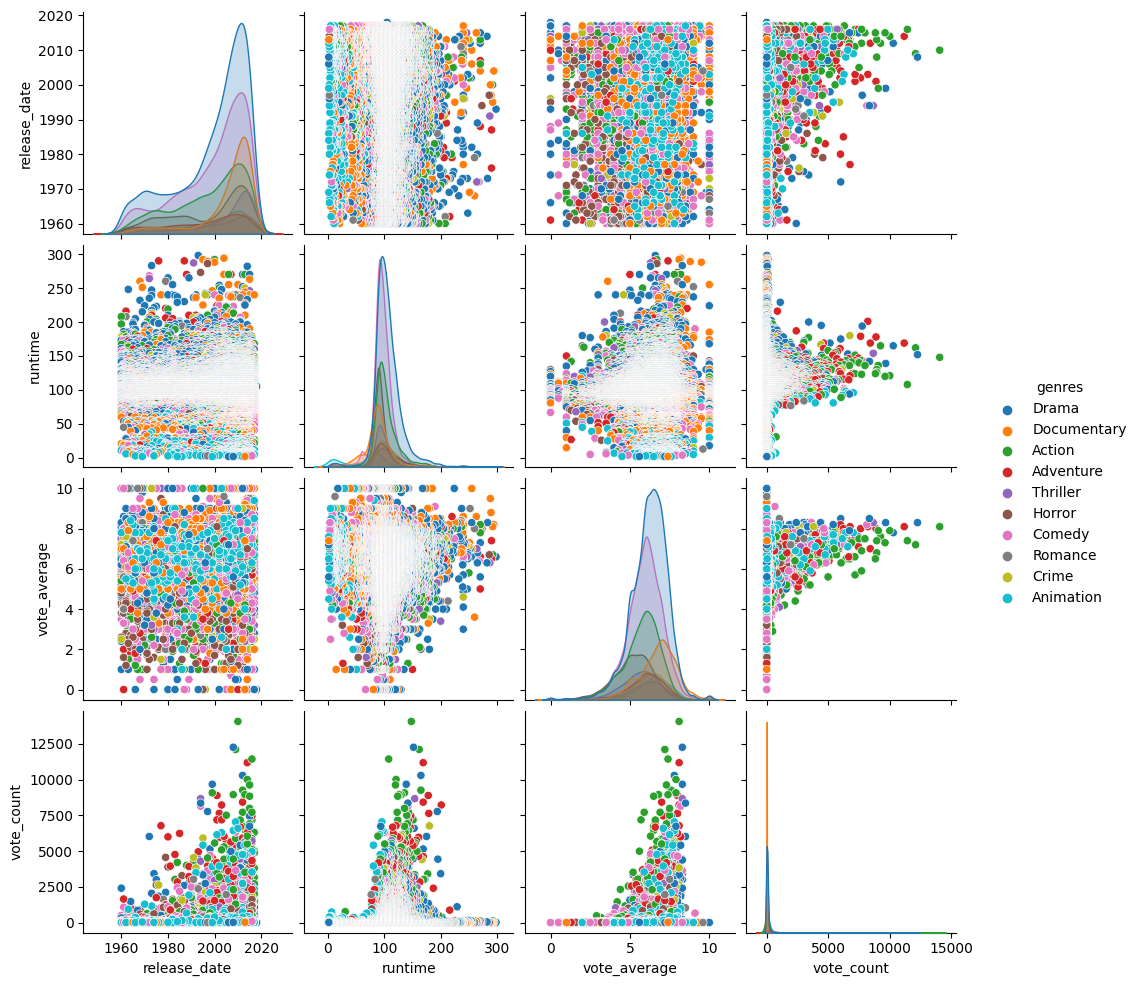

In [10]:
#macierze pomyłek
from sklearn.naive_bayes import GaussianNB
df2 = df2.dropna()
sns.pairplot(df2, kind="scatter", hue = "genres")
def split(df,proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,1:], df.iloc[:,0].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}
def verify(model,dane,atryb):
    model.fit(dane["opis_ucz"].iloc[:,atryb], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"].iloc[:,atryb])
    wynik_test = model.predict(dane["opis_test"].iloc[:,atryb])
    mp = confusion_matrix(dane["dec_ucz"],wynik_ucz)
    print("macierz pomyłek - zbiór uczący, dokładność:",np.sum(np.diag(mp))/np.sum(mp))
    learn_set_score = model.score(dane['opis_ucz'].iloc[:,atryb] ,dane['dec_ucz'])
    print(model.score(dane['opis_ucz'].iloc[:,atryb] ,dane['dec_ucz']))
    print(mp)
    mp = confusion_matrix(dane["dec_test"],wynik_test)
    print("macierz pomyłek - zbiór testowy, dokładność:",np.sum(np.diag(mp))/np.sum(mp))
    test_set_score = model.score(dane['opis_test'].iloc[:,atryb] ,dane['dec_test'])
    print(model.score(dane['opis_test'].iloc[:,atryb] ,dane['dec_test']))
    print(mp)
    return (learn_set_score, test_set_score) 

model = GaussianNB()
try_count = 5
learn_set_score = 0
test_set_score = 0
for k in range(0, try_count):
    data = split(df2, 0.3)
    atryb = [3, 5, 6]
    learn_score, test_score = verify(model, data, atryb)
    learn_set_score += learn_score
    test_set_score += test_score
print('Średnia dokładność z ' + str(try_count) + ' prób wynosi dla zbioru uczącego ' + str(learn_set_score / try_count) + ' , a dla zbioru testowego ' + str(test_set_score / try_count))

Podobne macierze, tym razem porównane z klasyfikatorem k-nn, dla różnych ilości sąsiadów.

In [11]:
for k in range(5, 80, 5):
    print('kneighbours : ' + str(k))
    model = KNeighborsClassifier(k)
    data = split(df2, 0.3)
    atryb = [3, 5, 6]
    verify(model, data, atryb)

kneighbours : 5
macierz pomyłek - zbiór uczący, dokładność: 0.4853299049543138
0.4853299049543138
[[1464   25   27  412   27   59  624   84    4   27]
 [ 181  228   18  143    6   32  213   36    4    6]
 [  81   34  303   97    4   58   73   21    0    4]
 [ 559   89   80 2751   24  195  973  125    7   28]
 [ 156   33   17  175  112   32  249   25    2    3]
 [ 152   36   49  337    9  894  414   19    5   10]
 [ 642  103   70 1064   66  323 4267   77   10   26]
 [ 312   41   36  442   15   47  332  427    3   13]
 [ 129   13   20  136    4   35  220   14   21    5]
 [ 202   39   20  253   15   32  295   49    3  103]]
macierz pomyłek - zbiór testowy, dokładność: 0.27790872080565676
0.27790872080565676
[[ 260   48   23  340   16   41  403   60    1   15]
 [  72   21   16   97    6    9  122    8    3    5]
 [  37   18   84   58    1   28   50   10    0    5]
 [ 358   43   52  676   21  128  667   86    3   47]
 [  76    5    5   90   10   13  136   15    1    2]
 [  91   11   31  179

Jak widać, dla liczby sąsiadów k=40, klasyfikator działa w pewnym stopniu - ze skutecznością około 40%.

Kontynuując przygotowania do uczenia na danych tekstowych, zdecydowaliśmy się zlematyzować opisy filmów(Overview) w celu zmniejszenia worka słów oraz poprawienia wyników uczenia maszynowego. 

In [12]:
#lematyzacja
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def checkWordType(word):    #Pomocnicza
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lematize(words):       #Lematyzuje zdania/ciągi słów i zmienia na małe litery
    result=[]
    for word in words:
        word=lemmatizer.lemmatize(word,checkWordType(word))
        result.append(word)
    return result

def removeStops(words):     #Usuwa stopy z listy słów (i psuje kolejność)
    return list(set(words)-set(stopwords.words('english')))

def cleanup_words_to_string(strings): #Oczyszcza listę słów ze stopów i lematyzuje je
    result=""
    for word in removeStops(lematize(strings)):
        result+=word+" "
    return result[0:-1]

def cleanup_words_to_list(string): #To co funkcja wyżej, ale zwraca listę zamiast długiego sklejanego łańcucha
    return removeStops(lematize(string))
     
df2['overview'] = [cleanup_words_to_list(x) for x in df2['overview']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/azureuser/nltk_data...


Po lematyzacji porównaliśmy słowa z wszystkich gatunków metryką kosinusową i wyznaczyliśmy macierz błędu podobieństwa, z której możemy odczytać najbardziej podobne do siebie gatunki.

Liczby słów w haśle
Drama  ->  38022
Comedy  ->  32902
Action  ->  22473
Documentary  ->  20640
Horror  ->  14136
Thriller  ->  11453
Adventure  ->  11362
Crime  ->  10040
Animation  ->  10316
Romance  ->  9518


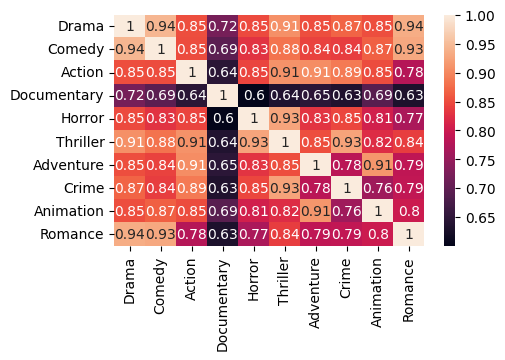

In [15]:

def odleglosc(x, y, typ = 'kosinusowa'):
    if typ == 'kosinusowa':
        return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
    elif typ == 'Euklidesowa':
        return np.sqrt(np.sum((x - y) ** 2))
    else: # miejska
        return np.sum(np.abs(x - y))

genres_strings = OrderedDict.fromkeys(wanted_genres)
for key in genres_strings.keys():
    genres_strings[key] = ""

def make_combined_string_of_every_genre(row):
    for word in row[1]:
        genres_strings[row[0]] += " " + word

[make_combined_string_of_every_genre(x) for x in zip(df2['genres'], df2['overview'])]
[make_combined_string_of_every_genre(x) for x in zip(df2['genres'], df2['title'])]

genres_strings = list(genres_strings.values())

print("Liczby słów w haśle")
for i in range(0,len(wanted_genres)):
    print(wanted_genres[i]," -> ",len(wordlists[wanted_genres[i]]))

w = CountVectorizer()
s = np.array(w.fit_transform(genres_strings).todense())
s.shape

typ_odleglosci = "kosinusowa"
#typ_odleglosci = 'Euklidesowa'
mac_odl = np.empty([len(wanted_genres),len(wanted_genres)])
for i in range(0,len(wanted_genres)):
    for j in range(0,len(wanted_genres)):
        mac_odl[i,j] = odleglosc(s[i],s[j])
plt.figure(figsize=(5,3),dpi = 100)
sns.heatmap(pd.DataFrame(mac_odl, index = wanted_genres, columns = wanted_genres),annot = mac_odl)

Z macierzy wynika, że dramat i komedia mają dużo podobnych słow, jednak zdecydowaliśmy się ich nie łączyć, ponieważ są to z zasady zupełnie inne gatunki, natomiast można również zauważyć, że horror, thriller i action mają dużo wspólnych słów, więc zdecydowaliśmy się połączyć te trzy gatunki w jeden.

In [16]:
#funkcje pomocnicze
def merge_list_to_string(words):
    words_string = ""
    for word in words:
        words_string += " " + word
    return words_string

def build_training_text_data():
    test_data = []
    for element in df2['overview']:
        test_data.append(element)

    test_data = [merge_list_to_string(x) for x in test_data]

    test_target = []
    for element in df2['genres']:
        test_target.append(wanted_genres.index(element))
    
    return (test_data, test_target)

def classify_text(model, transform, test_data, test_target):
    #rozdział na dane uczące i testowe
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(test_data, test_target, test_size=0.3)

    #stworzenie modelu
    model = make_pipeline(transform, model)

    #uczenie modelu
    model.fit(opis_ucz, dec_ucz)

    #testowanie modelu
    predicted_categories = model.predict(opis_test)
    print(predicted_categories)
    test_score = model.score(opis_test, dec_test)
    learn_score = model.score(opis_ucz, dec_ucz)

    # macierz błędu
    mat = confusion_matrix(dec_test, predicted_categories)
    sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()

    return(learn_score, test_score)


def test_text_classification(model, transform, try_count, test_data, test_target):
    learn_set_score = 0
    test_set_score = 0
    for k in range(0, try_count):
        data = split(df2, 0.3)
        learn_score, test_score = classify_text(model, transform, test_data, test_target)
        learn_set_score += learn_score
        test_set_score += test_score
    print('Średnia dokładność z ' + str(try_count) + ' prób wynosi dla zbioru uczącego ' + str(learn_set_score / try_count) + ' , a dla zbioru testowego ' + str(test_set_score / try_count))


['Drama', 'Comedy', 'Documentary', 'Horror', 'Thriller', 'Adventure', 'Animation']
[0 1 0 ... 0 0 0]
0.5061067066638097


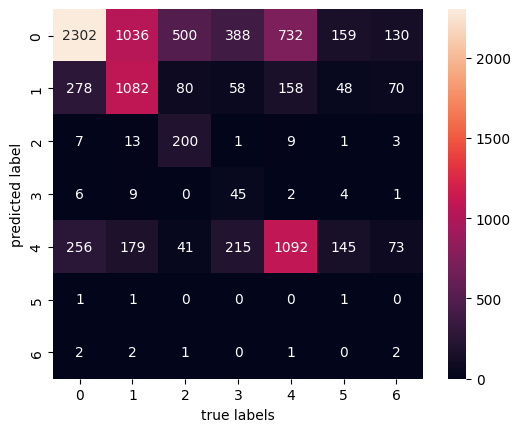

In [17]:
genres_to_merge = [['Thriller', 'Crime', 'Action']]
def merge_genres(x):
    for genres in genres_to_merge:
        if x in genres:
            return genres[0]
    return x

def remove_genres_from_list(genres_to_merge):
    for element in genres_to_merge:
        if(element!=genres_to_merge[0]) and (element in wanted_genres):
            wanted_genres.remove(element)


df2['genres'] = [merge_genres(x) for x in df2['genres']]
remove_genres_from_list(genres_to_merge[0])

genres_to_merge = [['Comedy', 'Romance']]
df2['genres'] = [merge_genres(x) for x in df2['genres']]
remove_genres_from_list(genres_to_merge[0])

test_data=[]
test_target=[]


for element in df2['overview']:
    overview = ' '.join(element)
    test_data.append(overview)

for element in df2['genres']:
    test_target.append(wanted_genres.index(element))

opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(test_data, test_target, test_size=0.3)
#combined_classifier = VotingClassifier([('kneighbors', KNeighborsClassifier(40)), ('SVM', SVC())], voting = 'soft', weights = [0.4, 0.58])
model = make_pipeline(TfidfVectorizer(lowercase=True, stop_words='english'), MultinomialNB(fit_prior=False))
#model = make_pipeline(TfidfVectorizer(lowercase=True, stop_words='english'), combined_classifier)


model.fit(opis_ucz, dec_ucz)

print(wanted_genres)
predicted_categories = model.predict(opis_test)
print(predicted_categories)
prediction = model.score(opis_test, dec_test)
print(prediction)

# plot the confusion matrix
dec_test_names = []
for i in range(len(dec_test)):
    dec_test_names.append(wanted_genres[dec_test[i]])

predicted_categories_names = []
for i in range(len(predicted_categories)):
    predicted_categories_names.append(wanted_genres[predicted_categories[i]])

mat = confusion_matrix(dec_test, predicted_categories)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

[0 1 0 ... 0 0 0]
0.5543175487465181
[4]


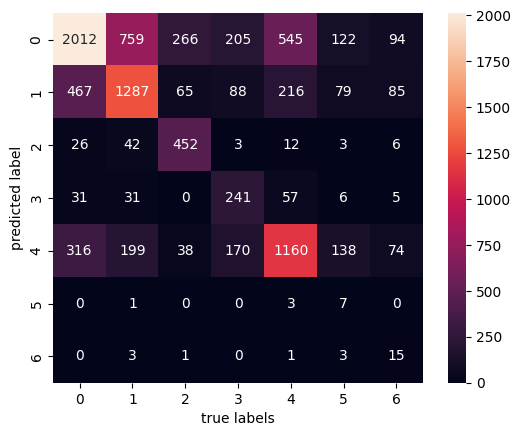

In [18]:
model = make_pipeline(TfidfVectorizer(lowercase=True, stop_words='english'), SVC())

model.fit(opis_ucz, dec_ucz)

predicted_categories = model.predict(opis_test)
print(predicted_categories)
prediction = model.score(opis_test, dec_test)
prediction2 = model.predict(['man tries to kidnap a woman in a park'])
print(prediction)
print(prediction2)

# plot the confusion matrix
dec_test_names = []
for i in range(len(dec_test)):
    dec_test_names.append(wanted_genres[dec_test[i]])

predicted_categories_names = []
for i in range(len(predicted_categories)):
    predicted_categories_names.append(wanted_genres[predicted_categories[i]])

mat = confusion_matrix(dec_test, predicted_categories)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

In [132]:
prediction = model.predict(['man tries to kidnap a woman in a park'])
print('Predykcja dla thrillera:', wanted_genres[prediction[0]])
prediction = model.predict(['a lot of blood and scary monsters'])
print('Predykcja dla horroru:', wanted_genres[prediction[0]])
prediction = model.predict(['tragic life of man and a woman'])
print('Predykcja dla dramatu:', wanted_genres[prediction[0]])
prediction = model.predict(['movie full of laughs and funny moments'])
print('Predykcja dla komedii:', wanted_genres[prediction[0]])
prediction = model.predict(['story of a great music composer, based on a true story'])
print('Predykcja dla dokumentu:', wanted_genres[prediction[0]])
prediction = model.predict(['story full of adventures and fantasies'])
print('Predykcja dla filmu przygodowego:', wanted_genres[prediction[0]])
prediction = model.predict(['an animation of your favourite cartoon characters'])
print('Predykcja dla filmu animowanego:', wanted_genres[prediction[0]])

Predykcja dla thrillera: Thriller
Predykcja dla horroru: Horror
Predykcja dla dramatu: Drama
Predykcja dla komedii: Comedy
Predykcja dla dokumentu: Drama
Predykcja dla filmu przygodowego: Drama
Predykcja dla filmu animowanego: Comedy


Wnioski: <br><br> 
-Zbiory danych, które są dostępne bywają wybrakowane i trzeba dużo pracy włożyć w przefiltrowanie tych danych i przerobienie ich do postaci nadającej się do uczenia maszynowego. W wybraniu danych do usunięcia pomagają histogramy, oraz ścisłe określenie jakich danych poszukujemy, a jakie możemy uznać za wadliwe lub niepotrzebne.<br><br>
-Liczba poprawnie sklasyfikowanych filmów danego gatunku przez klasyfikator SVC jest większa niż suma niepoprawnie sklasyfikowanych gatunków przez ten klasyfikator.<br><br>
-Znaki stopu stanowią znaczną część danych tekstowych, i są wspólne dla wszystkich gatunków filmów. Dane te są tak podobne, że po porównaniu worków słów poszczególnych gatunków macierzą TDM otrzymuje się praktycznie macierz jednostkową. Dlatego lematyzacja oraz usuwania znaków stopu znacząco poprawiają dokładność klasyfikacji na podstawie opisu filmu.<br><br>
-Z klasyfikacji za pomocą naiwnego Bayesa widzimy, że najczęściej zgadzającymi się z rzeczywistością gatunkami są dramat, komedia i thriller, są to też gatunki, których było najwięcej w danych, a zarazem było przez to najwięcej różnych i unikalnych słów w tych gatunkach. Z testów wynika, że prawdopodobieństwo odgadnięcia gatunku wynosi około 50%. Nie jest to duże prawdopodobieństwo, ale jest znacząco lepsze od losowania gatunków (około 14% prawdopodobieństwa). Przy poprzednich próbach klasyfikacji prawdopodobieństwa były znaczenie niższe, i przerabianie danych klasyfikujących (takie jak lematyzacja, czy scalanie gatunków) powiększyło trafność klasyfikacji. Dla porównania użyliśmy też klasyfikatora SVC (również używanego do uczenia na bazie tekstu) i dzięki niemu osiągnęliśmy ponad 55% trafności, ale z drugiej strony uczenie i klasyfikacja ze pomocą tego klasyfikatora była czasochłonna (7 minut), w porównaniu do klasyfikacji Bayesem (kilka sekund). Daliśmy klasyfikatorom typowe opisy dla gatunków filmów do odgadnięcia i oba klasyfikatory dobrze poradziły sobie z thrillerem, horrorem, dramatem i komedią, a sam klasyfikator Bayesa dobrze odgadł jeszcze animację. Niestety dokumentu i filmu przegodowego nie udało się odganąć, pomimo dosyć oczywistych opisów. Podsumowując, nie jest to model, którego możnaby używać na codzień do odgadywania gatunku filmu, ponieważ na pewno są do tego lepsze narzędzia w internecie, jednak pokazuje on, że nierówna ilość informacji na temat danych może zaburzać klasyfikację i na korzyść nadmiarowych danych.<br><br>
-Język Python wymaga bardzo uważnego podejścia do typów danych, które nie są zdefiniowane w tym języku jawnie, jednak dalej mogą powodować błędy. W przeciwieństwie do innych języków Python nie pokaże błędów przed wykonaniem. 